In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import os

In [ ]:
# Define a function to clean the 'Household_Income' column by handling various formats
def clean_household_income(value):
    # Handle missing values by returning NaN
    if pd.isna(value): return np.nan
    value = str(value).lower().replace('$', '').replace(',', '').strip()
    # Handle ranges (e.g., "50,000-75,000") by calculating the average
    if '–' in value or '-' in value:
        parts = value.replace('–', '-').split('-')
        try: return (float(parts[0]) + float(parts[1])) / 2
        except: return np.nan
    # Handle values with '+' or '>=' by taking the lower bound
    if '+' in value or '>=' in value or '>' in value:
        try: return float(value.replace('+', '').replace('>=', '').replace('>', '').strip())
        except: return np.nan
    # Convert remaining values to float, return NaN if conversion fails
    try: return float(value)
    except: return np.nan

In [3]:
# Load the dataset
df = pd.read_csv('Pregnancy During the COVID-19 Pandemic.csv')
# Print the original shape to understand the dataset's size
print("Original Shape:", df.shape)

Original Shape: (10772, 16)


In [4]:
# Drop rows with missing 'NICU_Stay' values since it's the target variable
df = df.dropna(subset=['NICU_Stay'])
print("Shape after dropping missing NICU_Stay:", df.shape)

Shape after dropping missing NICU_Stay: (5534, 16)


In [5]:
# Subsample the dataset
df = df.sample(n=min(6000, len(df)), random_state=55)
print("Subsampled Shape:", df.shape)

Subsampled Shape: (5534, 16)


In [6]:
# Clean the 'Household_Income' column using the defined function
df['Household_Income'] = df['Household_Income'].apply(clean_household_income)

In [7]:
#Handle missing values in categorical columns by filling with the mode
for col in ['Maternal_Education', 'Delivery_Mode']:
    if col in df.columns and df[col].notna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Define numeric columns for preprocessing
numeric_cols = ['Maternal_Age', 'Household_Income', 'Edinburgh_Postnatal_Depression_Scale',
                'PROMIS_Anxiety', 'Gestational_Age_At_Birth', 'Birth_Length', 'Birth_Weight',
                'Threaten_Life', 'Threaten_Baby_Harm']
# Handle missing values in numeric columns by filling with the mean
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)

In [8]:
# Drop unnecessary columns as specified in the requirements
columns_to_drop = ['OSF_ID', 'Language', 'Threaten_Baby_Danger']
if 'Delivery_Date(converted to month and year)' in df.columns:
    columns_to_drop.append('Delivery_Date(converted to month and year)')
df = df.drop(columns=columns_to_drop, axis=1)
print("Shape after dropping columns:", df.shape)

Shape after dropping columns: (5534, 12)


In [9]:
# EDA
print("\nNICU_Stay value counts:\n", df['NICU_Stay'].value_counts())


NICU_Stay value counts:
 NICU_Stay
No     4986
Yes     548
Name: count, dtype: int64


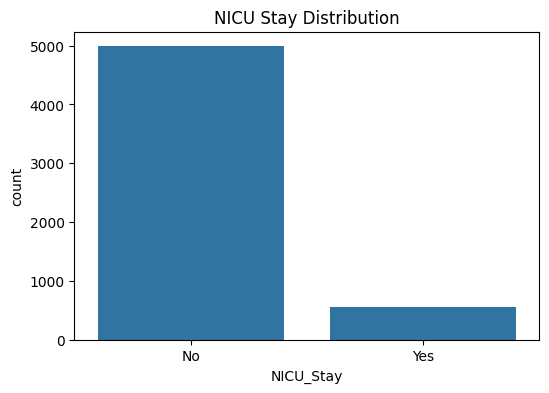

In [10]:
# Plot 1: NICU Stay Distribution (to visualize class imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(x='NICU_Stay', data=df)
plt.title('NICU Stay Distribution')
plt.savefig('nicu_stay_distribution.png')
plt.show()

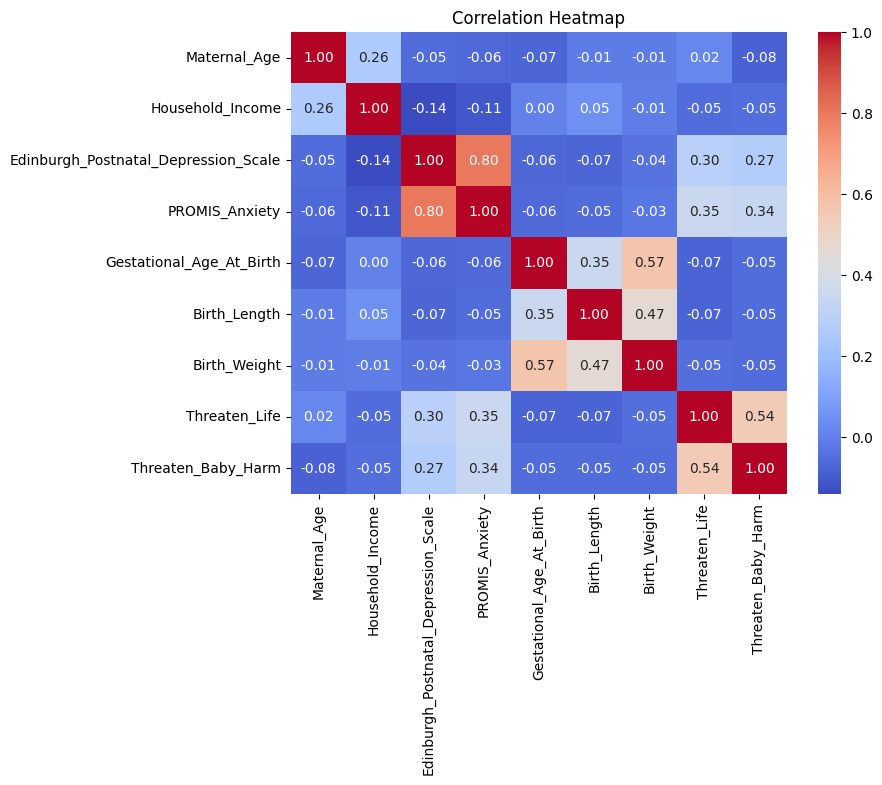

In [11]:
# Plot 2: Correlation Heatmap (to explore relationships between numeric features)
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

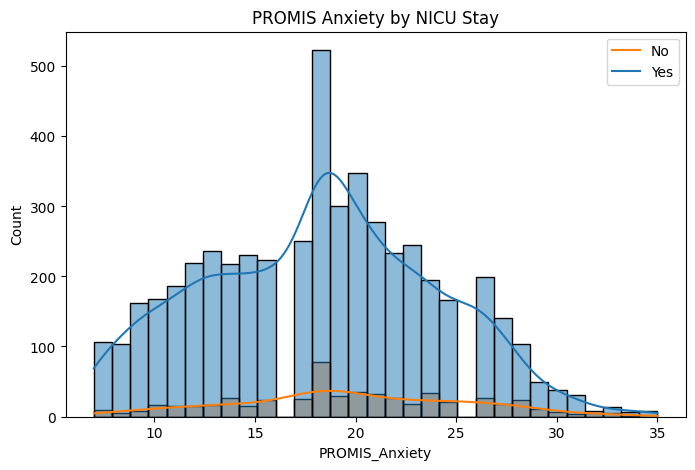

In [12]:
# Plot 3: PROMIS Anxiety by NICU Stay (to compare anxiety levels across classes)
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='PROMIS_Anxiety', hue='NICU_Stay', kde=True)
plt.title('PROMIS Anxiety by NICU Stay')
plt.legend(['No', 'Yes'])
plt.savefig('promis_anxiety_histogram.png')
plt.show()

In [13]:
# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in ['Maternal_Education', 'Delivery_Mode', 'NICU_Stay']:
    df[col] = le.fit_transform(df[col].astype(str))

In [14]:
# Separate features (X) and target (y)
X = df.drop('NICU_Stay', axis=1)
y = df['NICU_Stay']
# Scale the features
X_scaled = StandardScaler().fit_transform(X)
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=55, stratify=y)

In [15]:
# Apply SMOTE to address class imbalance in the training set
smote = SMOTE(random_state=55)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after SMOTE:
NICU_Stay
0    3489
1    3489
Name: count, dtype: int64


In [16]:
# Initialize models
models = {
    "k-NN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=55),
    "ANN": MLPClassifier(hidden_layer_sizes=(4,), max_iter=10000, random_state=55),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=55)
}


Model: k-NN (k=3)
Accuracy: 0.724
Classification Report:
               precision    recall  f1-score   support

          No       0.93      0.75      0.83      1497
         Yes       0.17      0.48      0.25       164

    accuracy                           0.72      1661
   macro avg       0.55      0.61      0.54      1661
weighted avg       0.85      0.72      0.77      1661


Model: k-NN (k=5)
Accuracy: 0.695
Classification Report:
               precision    recall  f1-score   support

          No       0.93      0.72      0.81      1497
         Yes       0.16      0.50      0.24       164

    accuracy                           0.70      1661
   macro avg       0.55      0.61      0.53      1661
weighted avg       0.85      0.70      0.75      1661


Model: Naive Bayes
Accuracy: 0.819
Classification Report:
               precision    recall  f1-score   support

          No       0.94      0.85      0.89      1497
         Yes       0.28      0.55      0.37       164

    

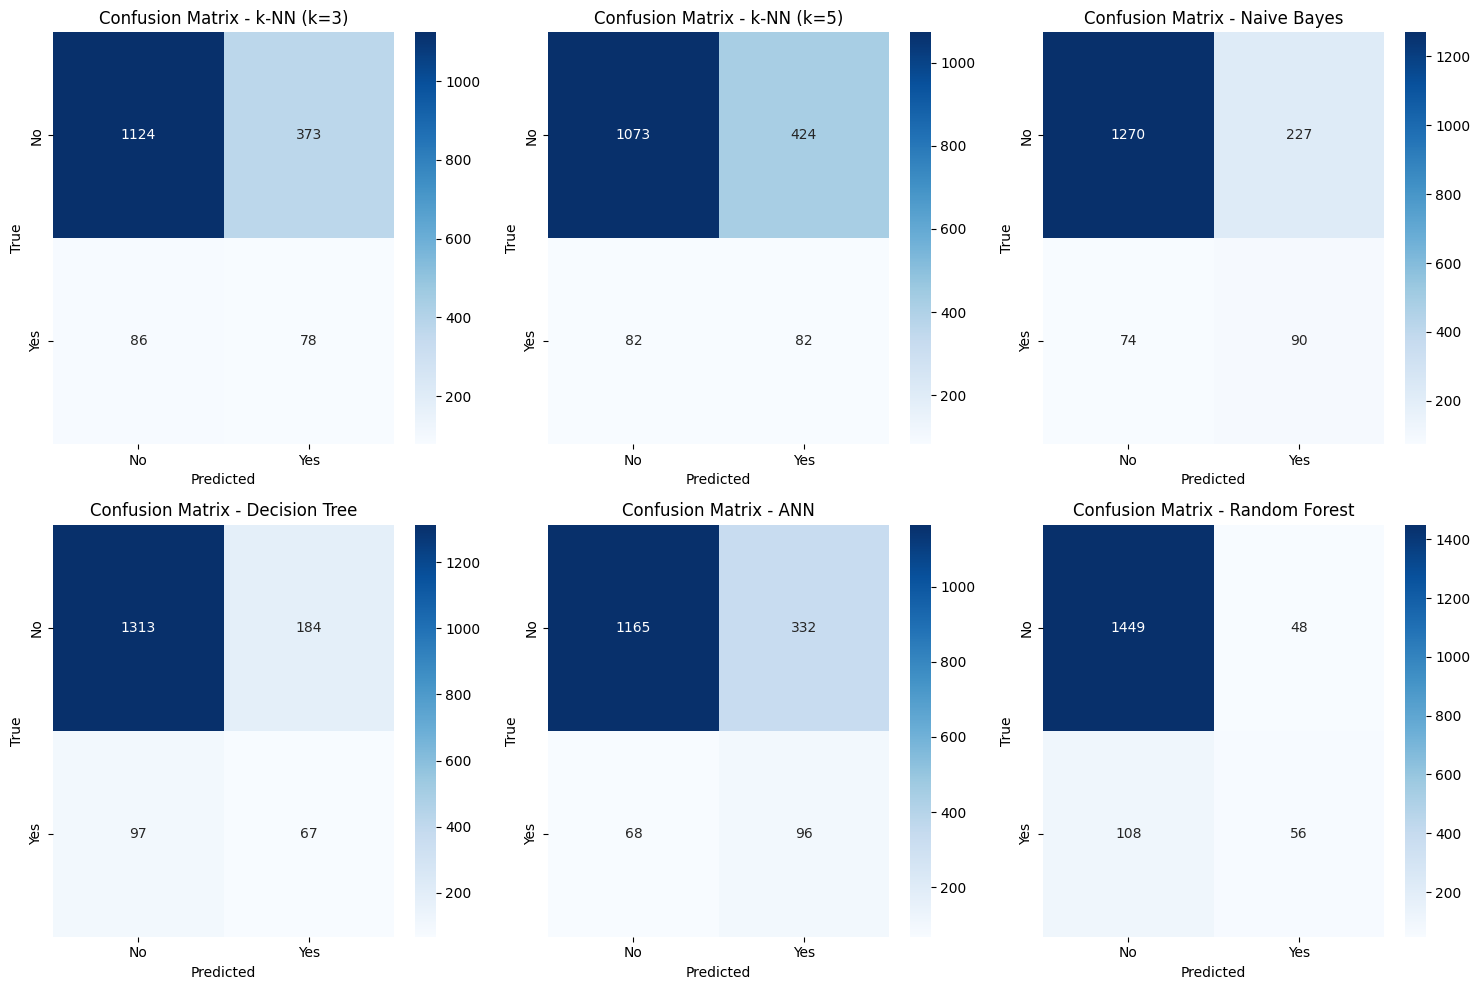

In [17]:
plt.figure(figsize=(15, 10))
for i, (model_name, model) in enumerate(models.items(), 1):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    # evaluation metrics
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['No', 'Yes'], zero_division=0))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

In [18]:
# k-Means Clustering with 2 clusters (binary target)
kmeans = KMeans(n_clusters=2, random_state=55, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)
print("\nk-Means Clustering:\n", pd.crosstab(y, clusters_kmeans, rownames=['Actual'], colnames=['Cluster']))


k-Means Clustering:
 Cluster     0     1
Actual             
0        2285  2701
1         359   189


In [19]:
# Hierarchical Clustering with 2 clusters
hier = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='average')
clusters_hier = hier.fit_predict(X_scaled)
print("\nHierarchical Clustering:\n", pd.crosstab(y, clusters_hier, rownames=['Actual'], colnames=['Cluster']))


Hierarchical Clustering:
 Cluster     0   1
Actual           
0        4986   0
1         517  31
